In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import galsim
import tensorflow as tf
import tensorflow_hub as hub
from galaxy2galaxy import problems
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load autoencoder model
encoder = hub.Module('modules/vae_final_pixel_tv_0.01/1592252412/encoder')
decoder = hub.Module('modules/vae_final_pixel_tv_0.01/1592252412/decoder')

In [4]:
# Load latent flow model
sampler = hub.Module('modules/flow_pixel_tv_0.01/1592567545/code_sampler/')

In [5]:
Modes = tf.estimator.ModeKeys
cosmos128 = problems.problem('attrs2img_cosmos128')
dset = cosmos128.dataset(Modes.EVAL, data_dir='/data2/g2g/datasets/cosmos128')
dset = dset.repeat().batch(128)
batch = dset.make_one_shot_iterator().get_next()

INFO:tensorflow:Reading data files from /data2/g2g/datasets/attrs2img_cosmos128/attrs2img_cosmos128-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [6]:
code = encoder({'input': batch['inputs'], 'psf': batch['psf']})
samples = sampler({'flux_radius':batch['flux_radius'], 'zphot':batch['zphot'], 'mag_auto':batch['mag_auto'],
                   'random_normal':tf.random_normal(shape=[128, 16])})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
# Assessing the distribution of codes
codes = []
params = []
codes_fake = []

for i in range(10):
    c,fr,tc = sess.run([samples, batch['mag_auto'], code])
    codes.append(tc.reshape((-1,16)))
    params.append(fr)
    codes_fake.append(c.reshape((-1,16)))
    
codes = concatenate(codes)
params = concatenate(params)
codes_fake = concatenate(codes_fake)

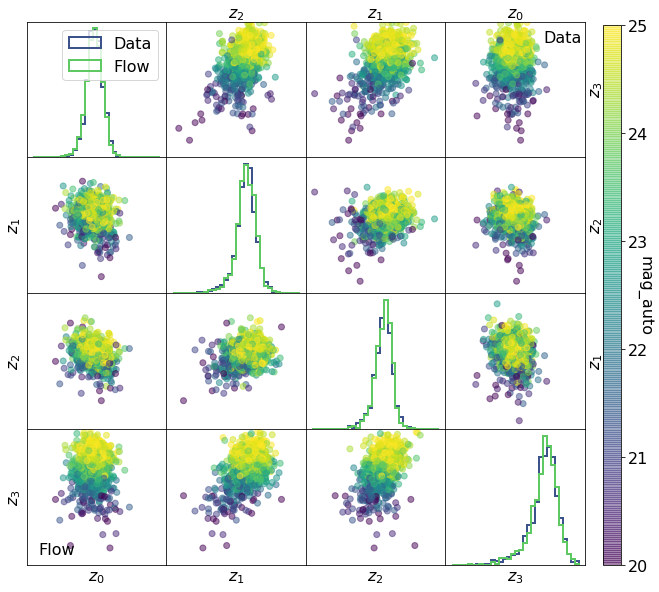

In [42]:
font = {'size'   : 16}
matplotlib.rc('font', **font)

offset=8
fig = figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        subplot(4,4,i+j*4+1)
        if i < j:
            scatter(codes_fake[:,i+offset], codes_fake[:,j+offset], c=params, vmax=25, vmin=20, alpha=0.5); 
            #axis('off')
            xlim(-5,5)
            ylim(-5,5)
            
        elif i > j:
            sc = scatter(codes[:,3-i+offset], codes[:,3-j+offset], c=params, vmax=25,vmin=20, alpha=0.5); 
            #axis('off')
            xlim(-5,5)
            ylim(-5,5)
            
        else:
            hist(codes[:,i+offset],32, range=[-5,5], label='Data', linewidth=2, color=plt.cm.viridis(0.25), histtype=u'step', density=True);
            hist(codes_fake[:,i+offset], 32, range=[-5,5], label='Flow', linewidth=2, color=plt.cm.viridis(0.75), histtype=u'step', density=True);
            if i ==0:
                legend()
                
        if (i == 0) and (j>0): 
            ylabel(r'$z_{%i}$'%j)
            
        if (i == 3) and (j<3): 
            ylabel(r'$z_{%i}$'%(3-j))
            ax = plt.gca()
            ax.yaxis.set_label_position("right")
            
        if (j == 0) and (i>0): 
            xlabel(r'$z_{%i}$'%(3-i))
            ax = plt.gca()
            ax.xaxis.set_label_position("top")
            
        if (j==3): 
            xlabel(r'$z_{%i}$'%i)
        
        if (j==3) and (i==0):
            text(-4.2,-4.2,'Flow')
            
        if (j==0) and (i==3):
            text(2.,3.5,'Data')
            
        if j < 4:
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            
        if i >=0:
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left=False,      # ticks along the bottom edge are off
                right=False,         # ticks along the top edge are off
                labelleft=False) # labels along the bottom edge are off
            
subplots_adjust(wspace=0, hspace=0, right=0.9)
ax = fig.add_axes([0.925, 0.125, 0.025, 0.75])
cbar = fig.colorbar(sc, cax=ax);
cbar.set_label('mag_auto', rotation=270)
savefig('Figures/Figure_ConditionalFlow.png',bbox_inches='tight')